In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.auto import tqdm

from fastai.vision import *
from fastai.metrics import error_rate

ModuleNotFoundError: No module named 'fastai'

# Import data

## Images

Get filenames

In [2]:
file_names = os.listdir('Data/images')
file_names[:5]

['models', 'Test_0.jpg', 'Test_1.jpg', 'Test_10.jpg', 'Test_100.jpg']

**Divide into Train and Test sets**

In [3]:
train_filenames = []
test_filenames = []
for file_name in file_names:
    if 'Train' in file_name:
        train_filenames.append(file_name)
    else: 
        test_filenames.append(file_name)
print(f'There are {len(train_filenames)} train images and {len(test_filenames)} test images')

There are 1821 train images and 1822 test images


See a sample

In [4]:
img = cv2.imread(f'Data/images/{train_filenames[0]}')
img.shape

(1365, 2048, 3)

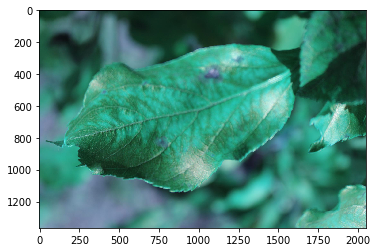

In [5]:
plt.imshow(img);

Load data into a numpy array with reduce image sizes

In [6]:
train_images = np.zeros((len(train_filenames), img.shape[0]//7,int((img.shape[0]//7)*1.5),3))
count = 0
for file in tqdm(train_filenames):
    image = cv2.imread(f'Data/images/{file}')
    small_img = cv2.resize(image, (int((img.shape[0]/7)*1.5), img.shape[0]//7), interpolation = cv2.INTER_CUBIC)
#     im_data = np.dot(small_img[...,:3], [0.2989, 0.5870, 0.1140])
#     im_data /= np.max(im_data)
    train_images[count,:,:,:] = small_img
    count += 1

In [ ]:
# test_images = np.zeros((img.shape[0]//7,int((img.shape[0]/7)*1.5),(len(test_filenames))))
# count = 0
# for file in tqdm(test_filenames):
#     image = cv2.imread(f'Data/images/{file}')
#     small_img = cv2.resize(image, (int((img.shape[0]/7)*1.5), img.shape[0]//7), interpolation = cv2.INTER_CUBIC)
#     im_data = np.dot(small_img[...,:3], [0.2989, 0.5870, 0.1140])
#     im_data /= np.max(im_data)
#     test_images[:,:,count] = im_data
#     count += 1

See the new sample

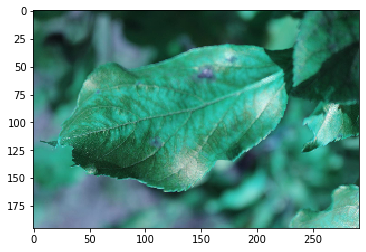

In [7]:
plt.imshow(np.array(train_images[0]).astype(np.int));

## Labels

In [8]:
train_labels = pd.read_csv('Data/train.csv')
test_labels = pd.read_csv('Data/test.csv')
train_labels.shape, test_labels.shape

((1821, 5), (1821, 1))

In [9]:
train_labels.head(2)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0


The images have a different order

In [10]:
train_labels['idx'] = train_labels.image_id.apply(lambda x: train_filenames.index(x+'.jpg'))
train_labels.sort_values(by='idx', inplace=True)
# test_labels['idx'] = test_labels.image_id.apply(lambda x: test_filenames.index(x+'.jpg'))
# test_labels.sort_values(by='idx', inplace=True)
train_labels.head()

,image_id,healthy,multiple_diseases,rust,scab,idx
0,Train_0,0,0,0,1,0
1,Train_1,0,1,0,0,1
10,Train_10,0,0,1,0,2
100,Train_100,1,0,0,0,3
1000,Train_1000,0,0,1,0,4


In [11]:
train_labels.loc[train_labels.healthy == 1, 'label'] = 'healthy'
train_labels.loc[train_labels.multiple_diseases == 1, 'label'] = 'multiple_diseases'
train_labels.loc[train_labels.rust == 1, 'label'] = 'rust'
train_labels.loc[train_labels.scab == 1, 'label'] = 'scab'
train_labels.head()

,image_id,healthy,multiple_diseases,rust,scab,idx,label
0,Train_0,0,0,0,1,0,scab
1,Train_1,0,1,0,0,1,multiple_diseases
10,Train_10,0,0,1,0,2,rust
100,Train_100,1,0,0,0,3,healthy
1000,Train_1000,0,0,1,0,4,rust


Some insight

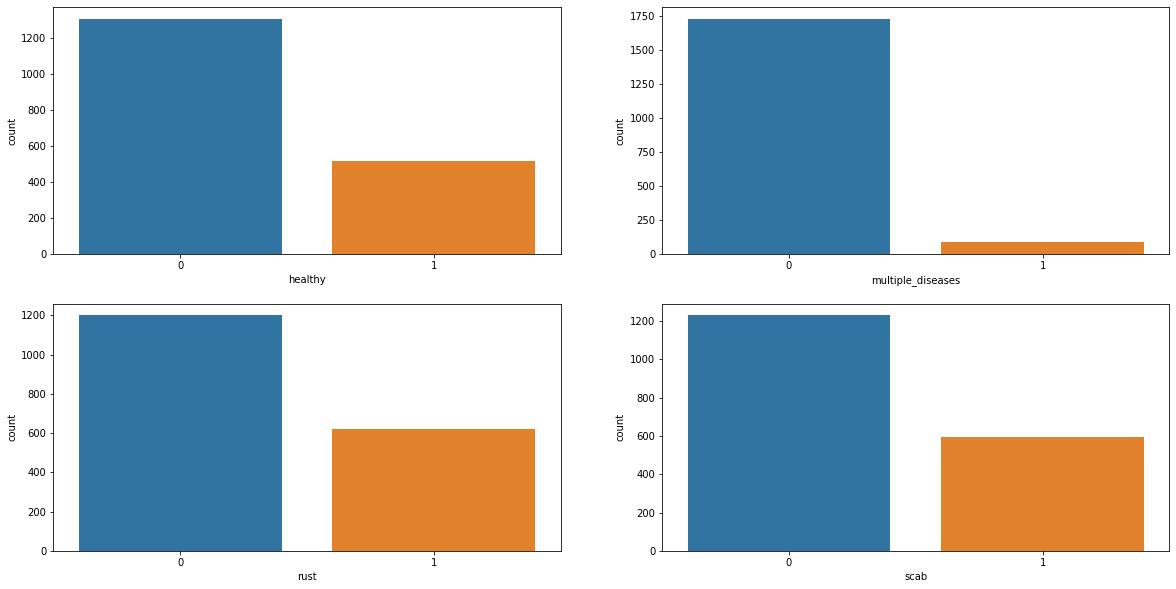

In [32]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
sns.countplot(train_labels.healthy, ax=ax[0,0])
sns.countplot(train_labels.multiple_diseases, ax=ax[0,1])
sns.countplot(train_labels.rust, ax=ax[1,0])
sns.countplot(train_labels.scab, ax=ax[1,1])
plt.show()

# Train - Test sets split

In [12]:
X_train = train_images[:int(len(train_images)*0.8),:,:]
X_test = train_images[int(len(train_images)*0.8):,:,:]
X_train.shape, X_test.shape

((1456, 195, 292, 3), (365, 195, 292, 3))

In [13]:
y_train = np.array(train_labels.label.iloc[:int(train_images.shape[0]*0.8)].values.tolist())
y_test = np.array(train_labels.label.iloc[int(train_images.shape[0]*0.8):].values.tolist())
len(y_train), len(y_test)

(1456, 365)

# Modeling

In [14]:
bs = 16

Puedo poner como label una lista de strings con la categoría a la que pertenece cada imagen.

In [15]:
data = ImageDataBunch.from_lists('Data/images', ['Data/images/' + s for s in train_filenames], list(train_labels.label),
                                 size=224, bs=bs).normalize(imagenet_stats)

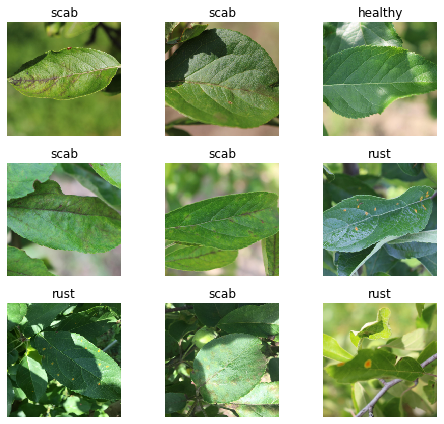

In [16]:
data.show_batch(rows=3, figsize=(7,6))

In [17]:
print(data.classes)
len(data.classes),data.c

['healthy', 'multiple_diseases', 'rust', 'scab']


(4, 4)

# Training: resnet34

In [18]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
# learn.load('model-resnet34')

In [20]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [22]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.927523,0.342256,0.085165,06:06
1,0.509488,0.305272,0.101648,04:15
2,0.347297,0.350896,0.101648,02:57
3,0.330666,0.310175,0.085165,03:03
4,0.285711,0.303993,0.079670,02:52
5,0.196776,0.298691,0.065934,03:12
6,0.164635,0.305063,0.074176,03:25
7,0.119522,0.293682,0.063187,02:57
8,0.093184,0.340486,0.063187,03:13
9,0.079759,0.305766,0.063187,03:18


In [23]:
learn.save('model-resnet34')

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

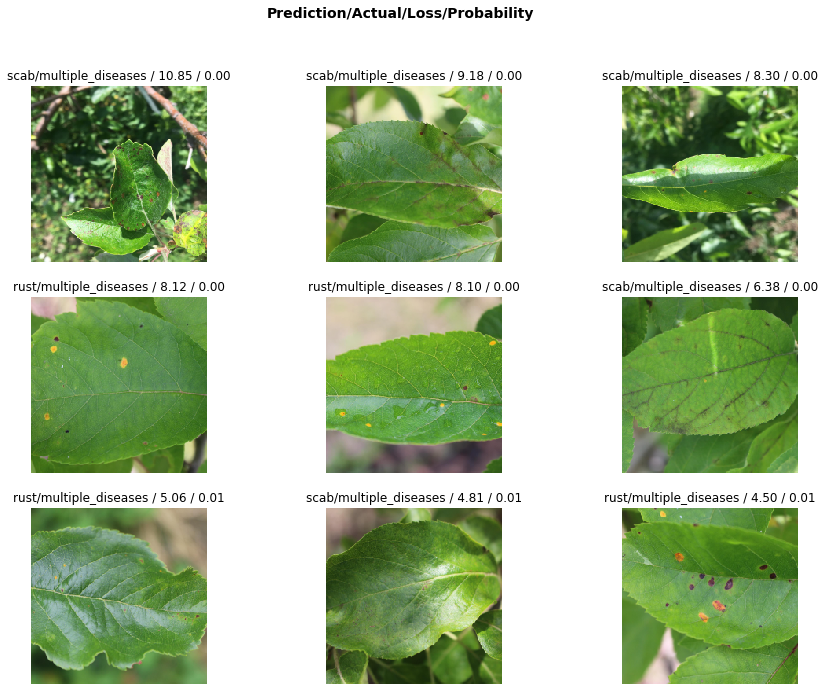

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

In [26]:
doc(interp.plot_top_losses)

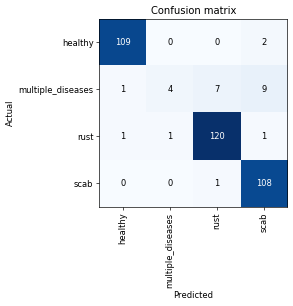

In [27]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [28]:
interp.most_confused(min_val=2)

[('multiple_diseases', 'scab', 9),
 ('multiple_diseases', 'rust', 7),
 ('healthy', 'scab', 2)]

In [29]:
cm = interp.confusion_matrix()

In [30]:
learn.unfreeze()

In [31]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


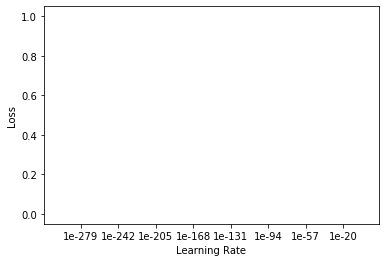

In [32]:
learn.recorder.plot()

## Training: resnet50

In [98]:
data = ImageDataBunch.from_lists('Data/images', ['Data/images/' + s for s in train_filenames], list(train_labels.healthy),
                                 size=224, bs=bs//16).normalize(imagenet_stats)

In [99]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 2.00 GiB total capacity; 1.28 GiB already allocated; 950.40 KiB free; 1.31 GiB reserved in total by PyTorch)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [87]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 1.26 GiB already allocated; 950.40 KiB free; 1.31 GiB reserved in total by PyTorch)

In [91]:
learn.save('model-resnet50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)